In [73]:
# A regex function that will remove links, special characters, digits, emojis, spaces, single letters
def cleaning_tweets(text):
    ''' Clean tweets with regex patterns
    
    Args : 
        - text : string
    
    Returns : 
        A transformed text
    '''

    text = str(text)
    text = text.lower()

    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = re.sub(r"\s+", " ", text)

    text = text.split()

    return text

In [74]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Loading the data into a DataFrame
df = pd.read_csv('../tweets/tweets_remaining_09042020_16072020.csv', delimiter=';')

# Creating new column with just the date
df['Date'] = df['created_at'].str.split().str[0]

# Deleting rows not containing amzn word in text
df = df[df['text'].str.contains("amzn")]

# VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Applying VADER to each tweet and storing the results in a new column
df['Sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Creating new DataFrame with only the date and sentiment columns
sentiment_df = df[['Date', 'Sentiment']]

# Creating new DataFrame with only the date and average sentiment columns
average_sentiment_df = sentiment_df.groupby('Date').mean().reset_index()

print(average_sentiment_df)


          Date  Sentiment
0   2020-04-09   0.169795
1   2020-04-10   0.162967
2   2020-04-11   0.103247
3   2020-04-12   0.174763
4   2020-04-13   0.178214
..         ...        ...
72  2020-07-12   0.136095
73  2020-07-13   0.167609
74  2020-07-14   0.114810
75  2020-07-15   0.126125
76  2020-07-16   0.120703

[77 rows x 2 columns]


In [75]:
import yfinance as yf

amzn_df = yf.download("amzn", start="2020-04-09", end="2020-07-16", progress=False)

In [76]:
average_sentiment_df['Date'] = pd.to_datetime(average_sentiment_df['Date'])


# deleting rows from average_sentiment_df that are not in amzn_df
average_sentiment_df = average_sentiment_df[average_sentiment_df['Date'].isin(amzn_df.index)]
# deleting rows from amzn_df that are not in average_sentiment_df
amzn_df = amzn_df[amzn_df.index.isin(average_sentiment_df['Date'])]
# reseting index in average_sentiment_df
average_sentiment_df = average_sentiment_df.reset_index(drop=True)
# reseting index in amzn_df
amzn_df = amzn_df.reset_index(drop=True)

In [77]:
# adding Sentiment from average_sentiment_df to amzn_df
amzn_df['Sentiment'] = average_sentiment_df['Sentiment'].to_numpy()

In [78]:
amzn_df["Tomorrow"] = amzn_df["Close"].shift(-1)

In [79]:
amzn_df["Target"] = (amzn_df["Tomorrow"] > amzn_df["Close"]).astype(int)


## SVM

In [80]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split(amzn_df[['Sentiment']], amzn_df['Target'], 
test_size=0.2, random_state=42, shuffle=False)

# training the model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# predicting the target
y_pred = model.predict(X_test)

test_df = amzn_df[amzn_df.index.isin(X_test.index)]
# dataframe with values from amzn_df for test set days
# adding predictions to test_df
test_df['Predictions'] = y_pred


/var/folders/9f/tqhf2_lj7x9g9w7kvpf8_91r0000gn/T/ipykernel_67910/3120402156.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = y_pred


In [81]:
print(test_df)
# reseting test_df index
test_df = test_df.reset_index(drop=True)


          Open        High         Low       Close   Adj Close     Volume   
41  134.253494  138.481506  133.751495  137.940994  137.940994   75394000  \
42  137.899506  144.750000  137.699997  143.934998  143.934998  127268000   
43  145.600494  147.778000  143.554993  144.514999  144.514999  131868000   
44  146.748505  152.994003  146.500000  152.852005  152.852005  137612000   
45  152.927505  153.477493  149.500000  150.005997  150.005997  105150000   
46  151.130493  154.198502  150.621506  154.055496  154.055496  100752000   
47  155.799500  159.694000  153.699997  159.131500  159.131500  127774000   
48  159.587997  160.750000  156.785004  160.000000  160.000000  109720000   
49  162.552994  167.214493  153.419495  155.199997  155.199997  154408000   
50  154.449997  156.369003  147.500000  154.199997  154.199997  144638000   
51  154.011505  154.917496  148.658997  150.443497  150.443497  115778000   

    Sentiment    Tomorrow  Target  Predictions  
41   0.122259  143.934998 

In [82]:
wallet = 10000
# adding the adj close price from test_df to wallet if the Predictions=Target=1, substracting if else
wallet_value = []  
for i in range(len(test_df)):
    if (test_df['Predictions'][i] == 1) and (test_df['Target'][i] == 1):
        wallet += (test_df['Tomorrow'][i] - test_df['Adj Close'][i])
    elif (test_df['Predictions'][i] == 0) and (test_df['Target'][i] == 0):
        wallet += (test_df['Adj Close'][i] - test_df['Tomorrow'][i])
    else:
        wallet -= abs((test_df['Tomorrow'][i] - test_df['Adj Close'][i]))
    wallet_value.append(wallet)

test_df['Wallet'] = wallet_value



          Open        High         Low       Close   Adj Close     Volume   
0     0.000000    0.000000    0.000000    0.000000    0.000000          0  \
1   134.253494  138.481506  133.751495  137.940994  137.940994   75394000   
2   137.899506  144.750000  137.699997  143.934998  143.934998  127268000   
3   145.600494  147.778000  143.554993  144.514999  144.514999  131868000   
4   146.748505  152.994003  146.500000  152.852005  152.852005  137612000   
5   152.927505  153.477493  149.500000  150.005997  150.005997  105150000   
6   151.130493  154.198502  150.621506  154.055496  154.055496  100752000   
7   155.799500  159.694000  153.699997  159.131500  159.131500  127774000   
8   159.587997  160.750000  156.785004  160.000000  160.000000  109720000   
9   162.552994  167.214493  153.419495  155.199997  155.199997  154408000   
10  154.449997  156.369003  147.500000  154.199997  154.199997  144638000   
11  154.011505  154.917496  148.658997  150.443497  150.443497  115778000   

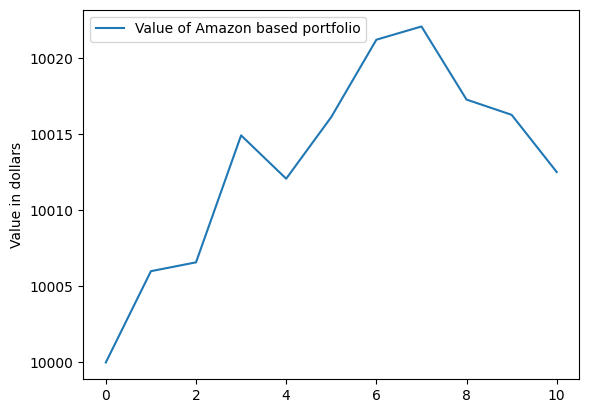

In [83]:
wallet_df = test_df.copy()
wallet_df = wallet_df.drop(wallet_df.index[0:60])

wallet_df.loc[-1] = [0] * len(wallet_df.columns)
wallet_df.index = wallet_df.index + 1
wallet_df = wallet_df.sort_index()
wallet_df.loc[0, 'Wallet'] = 10000


wallet_df = wallet_df.reset_index(drop=True)
wallet_df = pd.concat([wallet_df, test_df], ignore_index=True)


print(wallet_df)


plt.plot(wallet_df['Wallet'], label='Value of Amazon based portfolio')
plt.ylabel('Value in dollars')
plt.legend()
plt.show()



In [84]:
# Printing the return
print((wallet_df['Wallet'][len(wallet_df)-2] - wallet_df['Wallet'][0])/wallet_df['Wallet'][0]*100)


0.12502502441406252
